In [10]:
import numpy as np  
import pickle
from sklearn.decomposition import PCA
import gpflow

In [11]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    print(para_array)
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [12]:

def MGemuClosest(Om, ns, s8, fR0, n, z):

    closest_idx = (np.abs(z_all - z)).argmin() 
    GPm, PCAm = modelLoad(nRankMax, closest_idx)
    Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    print('Closest snap = ', closest_idx, 'at z= ', str(z_all[closest_idx]) )

    # else:
    #     snap_idx_nearest = (np.abs(z_all - z)).argmin()
    #     if (z > z_all[snap_idx_nearest]): 
    #         snap_ID_z1 = snap_idx_nearest - 1    
    #     else:
    #         snap_ID_z1 = snap_idx_nearest 
    #     snap_ID_z2 = snap_ID_z1 + 1

    #     GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
    #     Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
    #     z1 = z_all[snap_ID_z1]

    #     GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
    #     Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
    #     z2 = z_all[snap_ID_z2]
        
    #     print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        
    #     Pk_interp = np.zeros_like(Pk_z1)
    #     Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp

In [13]:
nRankMax = 16
snap_ID = 61
del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Emulator213bins/" ## Data folder
modelDir = "./Models/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')

In [14]:
# Om, ns, s8, fR0, n = 0.1, 1.0, 0.8, 3e-5, 1.5

# MGemu(Om=0.1, ns=1.0, s8=0.8, fR0=3e-5, n=1.5, z=0.02)

./Models/GP_smooth_rank16snap99
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
./Models/GP_smooth_rank16snap99
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/GP_smooth_rank16snap99
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-06
 1.00000000e+00]
[0.47178083 0.605      0.6        0.00990099 0.25      ]


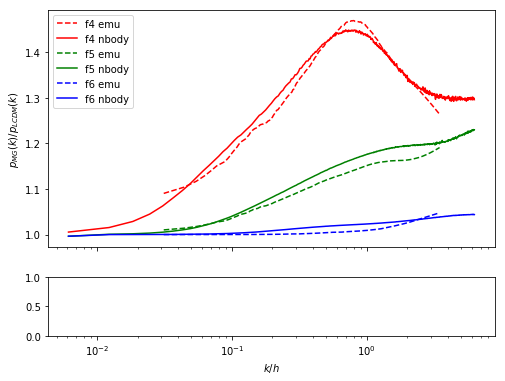

In [19]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f= 0.0 #0.505668030951772
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6


emu_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

import matplotlib.pylab as plt
# plt.clf()
# nbody = np.loadtxt('./Data/Nbody_validation/ratiosz05.txt', skiprows=1)
nbody = np.loadtxt('./Data/Nbody_validation/ratiosz_38.txt')


fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(wspace=0.25)

ax[0].plot(kvals, emu_f4, 'r--', label='f4 emu')
ax[0].plot(nbody[:,0], nbody[:, 1], 'r-', label='f4 nbody')


ax[0].plot(kvals, emu_f5, 'g--', label='f5 emu')
ax[0].plot(nbody[:,0], nbody[:, 2], 'g-', label='f5 nbody')

ax[0].plot(kvals, emu_f6, 'b--', label='f6 emu')
ax[0].plot(nbody[:,0], nbody[:, 3], 'b-', label='f6 nbody')
ax[0].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
# plt.xlim(1e-2, 1)
plt.show()

In [20]:
# common_min = np.max( [np.min(kvals), np.min(nbody[:,0])] )
# common_max = np.min( [np.max(kvals), np.max(nbody[:,0])] )
#print(common_min, common_max)

./Models/GP_smooth_rank16snap65
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
Closest snap =  65 at z=  0.4997
./Models/GP_smooth_rank16snap64
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
./Models/GP_smooth_rank16snap65
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
Linear interpolating for redshift between z1= 0.52207 z2= 0.4997
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/GP_smooth_rank16snap64
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/GP_smooth_rank16snap65
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
Linear in

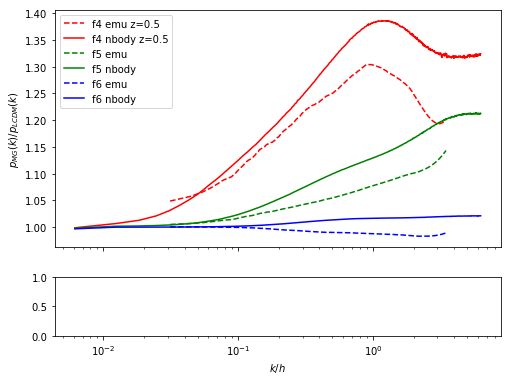

In [21]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f= 0.505668030951772
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

emu2_f4= MGemuClosest(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu1_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu1_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu1_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

nbody1 = np.loadtxt('./Data/Nbody_validation/ratios_27.txt', skiprows=1)

fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(wspace=0.25)

# ax[0].plot(kvals, emu_f4, 'k--', label='f4 emu z=0')
ax[0].plot(kvals, emu1_f4, 'r--', label='f4 emu z=0.5')
# ax[0].plot(kvals, emu2_f4, 'b--', label='f4 emu nearest z=0.5')
# ax[0].plot(nbody[:,0], nbody[:, 1], 'k-', label='f4 nbody z=0')
ax[0].plot(nbody1[:,0], nbody1[:, 1], 'r-', label='f4 nbody z=0.5')


ax[0].plot(kvals, emu1_f5, 'g--', label='f5 emu')
ax[0].plot(nbody1[:,0], nbody1[:, 2], 'g-', label='f5 nbody')

ax[0].plot(kvals, emu1_f6, 'b--', label='f6 emu')
ax[0].plot(nbody1[:,0], nbody1[:, 3], 'b-', label='f6 nbody')
ax[0].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
# plt.xlim(1e-2, 1)
plt.show()

./Models/GP_smooth_rank16snap70
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
./Models/GP_smooth_rank16snap71
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-04
 1.00000000e+00]
[0.47178083 0.605      0.6        1.         0.25      ]
Linear interpolating for redshift between z1= 0.397038 z2= 0.37817
Linear interpolating for snapshots  for z1= 70 and z2= 71
./Models/GP_smooth_rank16snap70
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
./Models/GP_smooth_rank16snap71
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00000000e-05
 1.00000000e+00]
[0.47178083 0.605      0.6        0.09990999 0.25      ]
Linear interpolating for redshift between z1= 0.397038 z2= 0.37817
Linear interpolating for snapshots  for z1= 70 and z2= 71
./Models/GP_smooth_rank16snap70
[1.36512329e-01 9.71000000e-01 8.20000000e-01 1.00

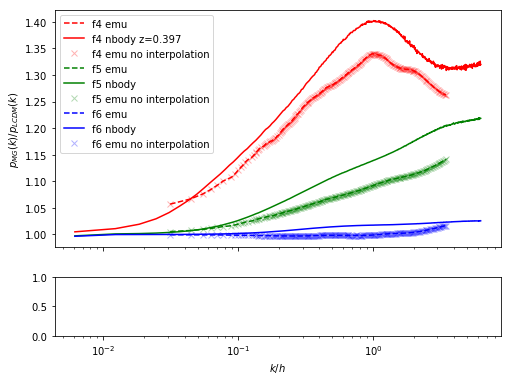

In [22]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
z_f = 0.397
n_f=1
fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6


emu2_f4= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_f)
emu2_f5= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_f)
emu2_f6= MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_f)

GPm, PCAm = modelLoad(nRankMax, 71)
Pk70_f4 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f4, n_f])
Pk70_f5 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f5, n_f])
Pk70_f6 = Emu(GPm, PCAm, [Om_f, ns_f, s8_f, fr0_f6, n_f])


nbody2 = np.loadtxt('./Data/Nbody_validation/ratios_29.txt', skiprows=1)
# nbody = np.loadtxt('./Data/Nbody_validation/ratiosz0.txt')

fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(wspace=0.25)

ax[0].plot(kvals, emu2_f4, 'r--', label='f4 emu')
ax[0].plot(nbody2[:,0], nbody2[:, 1], 'r-', label='f4 nbody z=%0.3f'%z_f)
ax[0].plot(kvals, emu2_f4, 'rx', alpha = 0.3, label='f4 emu no interpolation')


ax[0].plot(kvals, emu2_f5, 'g--', label='f5 emu')
ax[0].plot(nbody2[:,0], nbody2[:, 2], 'g-', label='f5 nbody')
ax[0].plot(kvals, emu2_f5, 'gx', alpha = 0.3, label='f5 emu no interpolation')


ax[0].plot(kvals, emu2_f6, 'b--', label='f6 emu')
ax[0].plot(nbody2[:,0], nbody2[:, 3], 'b-', label='f6 nbody')
ax[0].plot(kvals, emu2_f6, 'bx', alpha = 0.3, label='f6 emu no interpolation')

ax[0].set_xscale('log')

ax[0].legend()
ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
# plt.xlim(1e-2, 1)
plt.show()